In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import datetime
import os
import tqdm
import time
import glob
import pandas as pd
import xarray as xr
from dateutil.relativedelta import relativedelta

os.chdir('/Users/zach/Documents/Quadtree-MPNNLSTM')

from model.graph_functions import unflatten
from model.utils import normalize, int_to_datetime
from model.mpnnlstm import NextFramePredictorS2S
from model.seq2seq import Seq2Seq
from model.graph_functions import create_static_heterogeneous_graph

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from ice_dataset import IceDataset

In [2]:
device = torch.device('cpu')

# Defaults
convolution_type = 'TransformerConv'

training_years = range(2007, 2013)
x_vars = ['siconc', 't2m', 'v10', 'u10', 'sshf']
y_vars = ['siconc']
input_features = len(x_vars)
input_timesteps = 10
output_timesteps= 90

binary=False

# Set threshold 
thresh = -np.inf

# Arguments passed to Seq2Seq constructor
model_kwargs = dict(
    hidden_size=32,
    dropout=0.1,
    n_layers=1,
    dummy=False,
    n_conv_layers=3,
    rnn_type='LSTM',
    convolution_type=convolution_type,
)

month = 6
ds = xr.open_mfdataset(glob.glob('data/hb_era5_glorys_nc/*.nc'))
mask = np.isnan(ds.siconc.isel(time=0)).values

climatology = ds[y_vars].fillna(0).groupby('time.dayofyear').mean('time', skipna=True).to_array().values
climatology = torch.tensor(np.nan_to_num(climatology)).to(device)

graph_structure = create_static_heterogeneous_graph(mask.shape, 4, mask, use_edge_attrs=True, resolution=1/12, device=device)

data_val = IceDataset(ds, [2015], month, input_timesteps, output_timesteps, x_vars, y_vars)

experiment_name = f'M{str(month)}_Y{training_years[0]}_Y{training_years[-1]}_I{input_timesteps}O{output_timesteps}'

model = NextFramePredictorS2S(
    thresh=thresh,
    experiment_name=experiment_name,
    input_features=input_features,
    input_timesteps=input_timesteps,
    output_timesteps=output_timesteps,
    device=device,
    binary=binary,
    debug=False, 
    model_kwargs=model_kwargs)

results_dir = f'results/ice_results_jun19_with_shipping_route/'

model.load(results_dir)

class Sampler(SubsetRandomSampler):
    def __init__(self, indices):
        super().__init__(indices[:1])

xs = []
att_maps = []
for i in tqdm.tqdm(range(30)):
    loader_val = DataLoader(data_val, batch_size=1, shuffle=False, sampler=Sampler([i]))
    model.predict(loader_val, climatology, mask=mask, graph_structure=graph_structure)
    with open('scratch/attention_map.npy', 'rb') as f:
        x = np.load(f)
        att_map = np.load(f)
        
        xs.append(x)
        att_maps.append(att_map)
    print(i)

  0%|                                                                                                                               | 0/1 [00:00<?, ?it/s]/Users/zach/Documents/Quadtree-MPNNLSTM/model/model.py:93: UserWarning: Asked for attention weights.
  warnings.warn('Asked for attention weights.')

  3%|███▉                                                                                                                  | 1/30 [00:24<11:56, 24.72s/it]

0



  7%|███████▊                                                                                                              | 2/30 [00:52<12:27, 26.69s/it]

1



 10%|███████████▊                                                                                                          | 3/30 [01:16<11:20, 25.19s/it]

2



 13%|███████████████▋                                                                                                      | 4/30 [01:38<10:29, 24.22s/it]

3



 17%|███████████████████▋                                                                                                  | 5/30 [02:01<09:46, 23.46s/it]

4



 20%|███████████████████████▌                                                                                              | 6/30 [02:23<09:16, 23.17s/it]

5



 23%|███████████████████████████▌                                                                                          | 7/30 [02:45<08:44, 22.82s/it]

6



 27%|███████████████████████████████▍                                                                                      | 8/30 [03:13<08:57, 24.44s/it]

7



 30%|███████████████████████████████████▍                                                                                  | 9/30 [03:35<08:18, 23.74s/it]

8



 33%|███████████████████████████████████████                                                                              | 10/30 [03:58<07:45, 23.27s/it]

9



 37%|██████████████████████████████████████████▉                                                                          | 11/30 [04:24<07:38, 24.12s/it]

10



 40%|██████████████████████████████████████████████▊                                                                      | 12/30 [04:49<07:22, 24.57s/it]

11



 43%|██████████████████████████████████████████████████▋                                                                  | 13/30 [05:11<06:44, 23.81s/it]

12



 47%|██████████████████████████████████████████████████████▌                                                              | 14/30 [05:34<06:13, 23.37s/it]

13



 50%|██████████████████████████████████████████████████████████▌                                                          | 15/30 [05:56<05:46, 23.08s/it]

14



 53%|██████████████████████████████████████████████████████████████▍                                                      | 16/30 [06:18<05:20, 22.89s/it]

15



 57%|██████████████████████████████████████████████████████████████████▎                                                  | 17/30 [06:41<04:54, 22.67s/it]

16



 60%|██████████████████████████████████████████████████████████████████████▏                                              | 18/30 [07:03<04:29, 22.44s/it]

17



 63%|██████████████████████████████████████████████████████████████████████████                                           | 19/30 [07:25<04:05, 22.34s/it]

18



 67%|██████████████████████████████████████████████████████████████████████████████                                       | 20/30 [07:47<03:42, 22.28s/it]

19



 70%|█████████████████████████████████████████████████████████████████████████████████▉                                   | 21/30 [08:09<03:19, 22.16s/it]

20



 73%|█████████████████████████████████████████████████████████████████████████████████████▊                               | 22/30 [08:30<02:56, 22.03s/it]

21



 77%|█████████████████████████████████████████████████████████████████████████████████████████▋                           | 23/30 [08:52<02:34, 22.01s/it]

22



 80%|█████████████████████████████████████████████████████████████████████████████████████████████▌                       | 24/30 [09:14<02:12, 22.04s/it]

23



 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 25/30 [09:37<01:50, 22.19s/it]

24



 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 26/30 [09:59<01:28, 22.25s/it]

25



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 27/30 [10:22<01:06, 22.20s/it]

26



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 28/30 [10:44<00:44, 22.29s/it]

27



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 29/30 [11:06<00:22, 22.28s/it]

28



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [11:29<00:00, 22.97s/it]

29


In [4]:
from model.graph_functions import unflatten

with open('scratch/attention_map.npy', 'rb') as f:
    x = np.load(f)
    att_map = np.load(f)

att_map = unflatten(torch.Tensor(att_map), graph_structure['mapping'], mask.shape)
x = unflatten(torch.Tensor(x), graph_structure['mapping'], mask.shape)

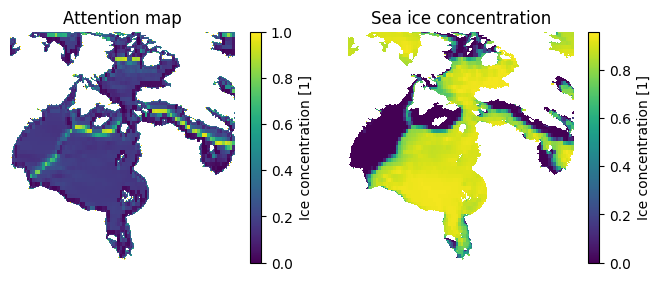

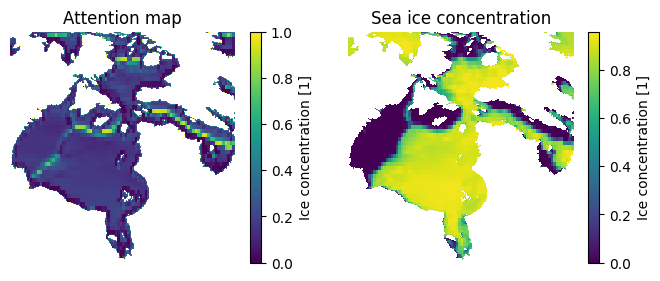

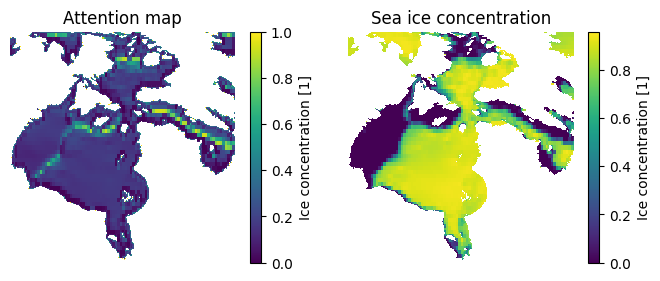

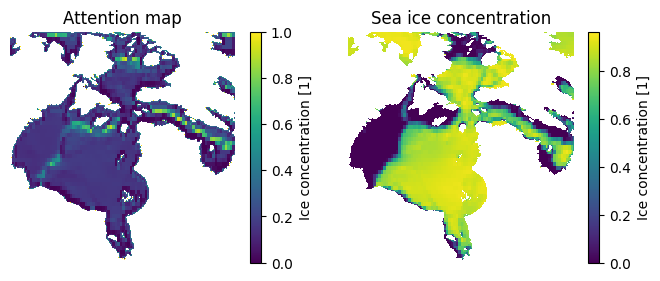

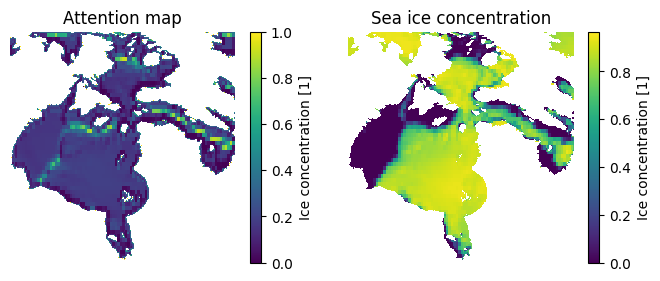

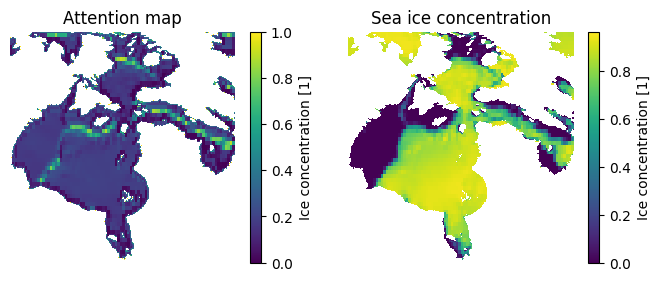

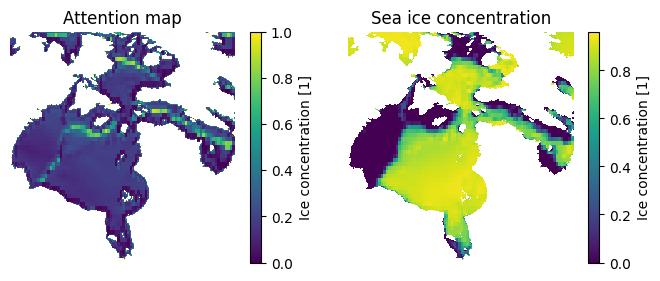

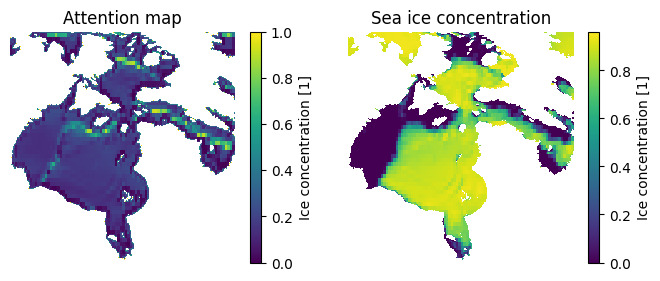

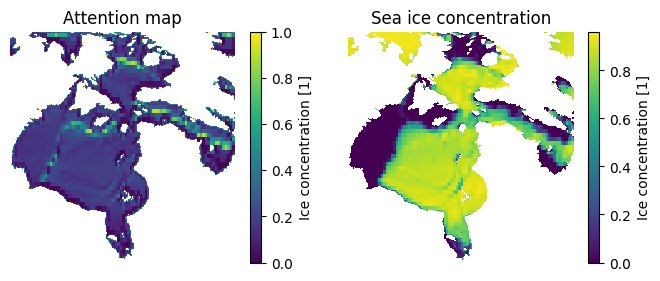

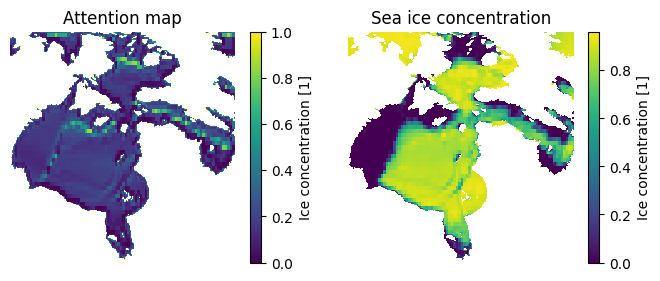

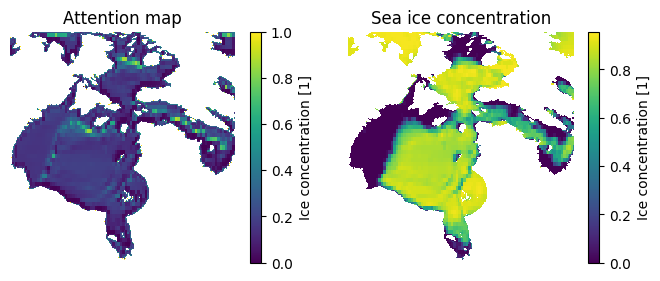

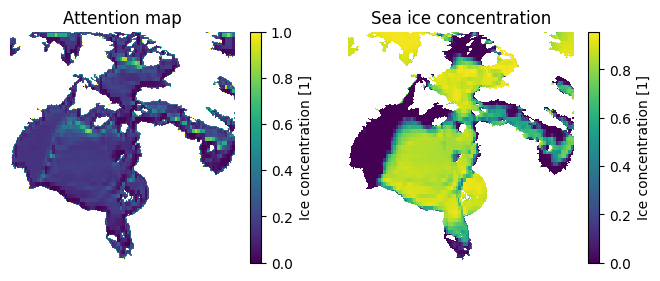

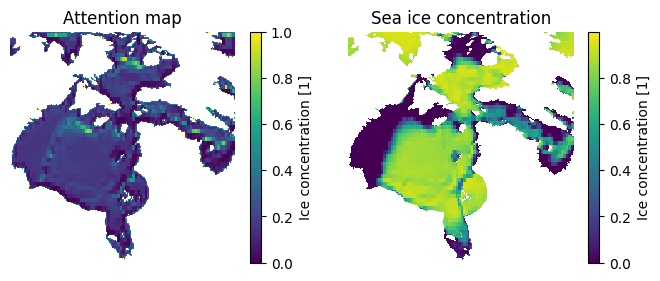

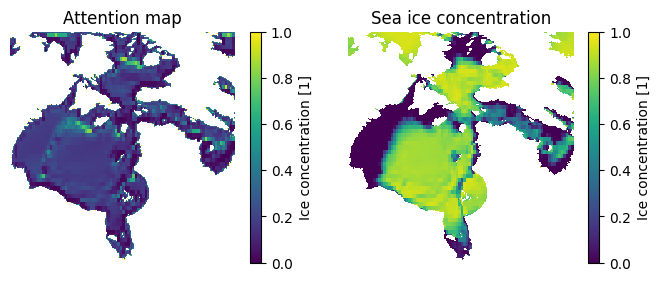

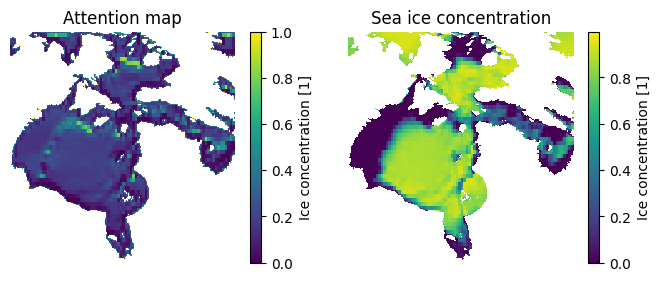

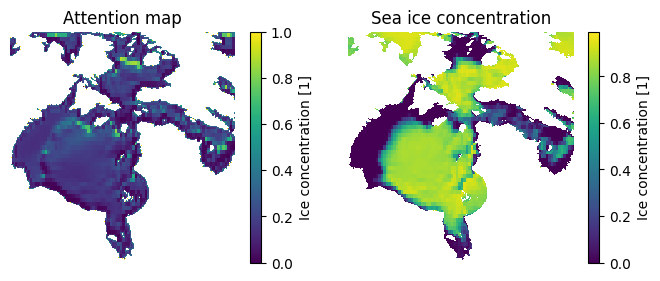

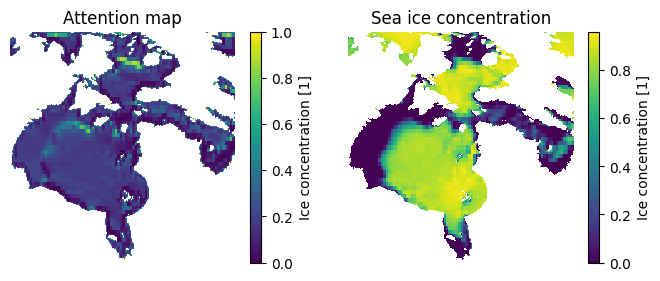

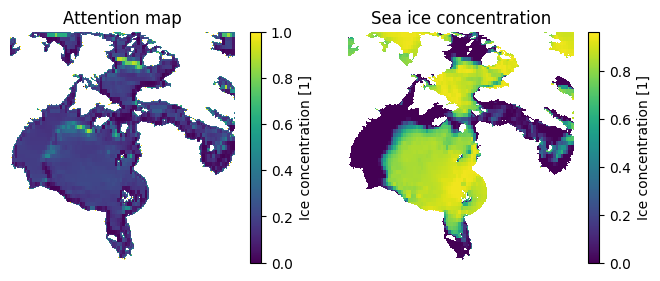

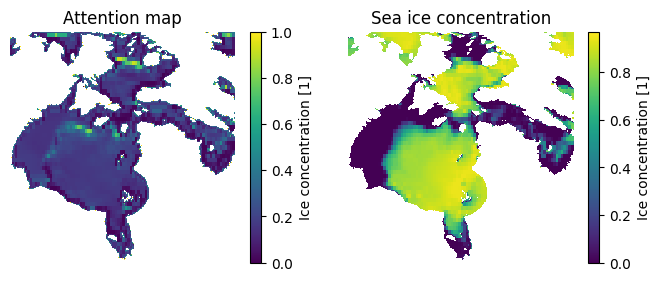

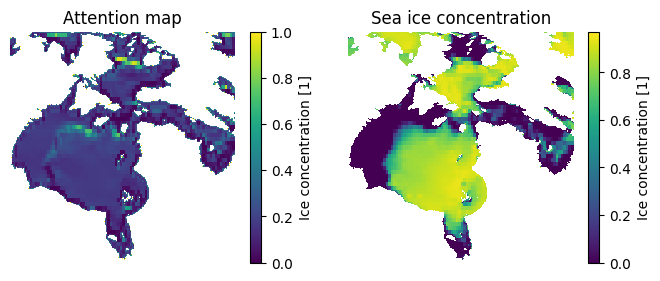

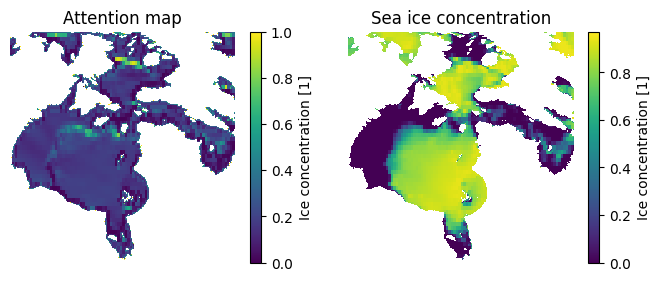

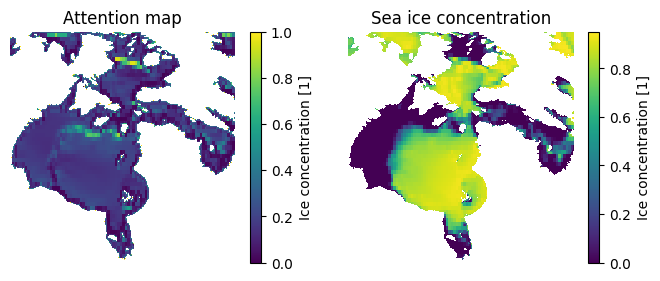

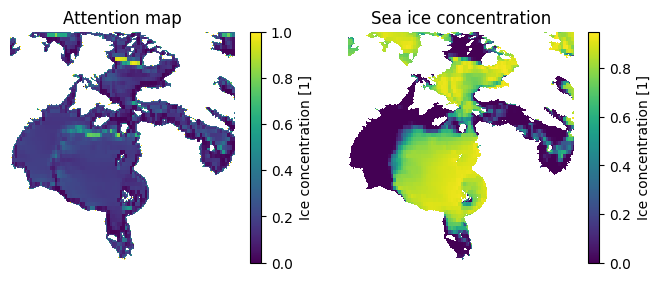

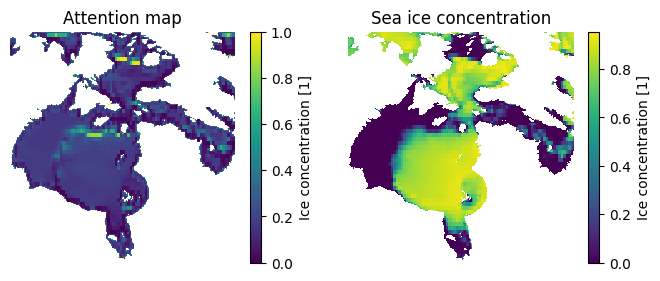

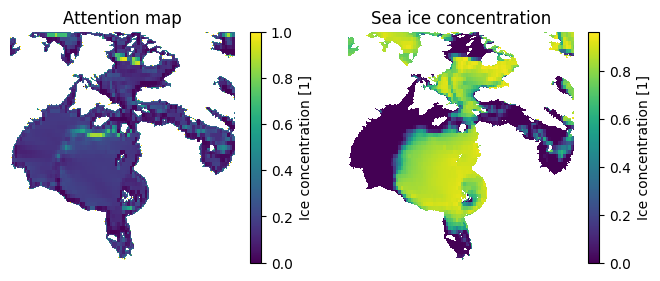

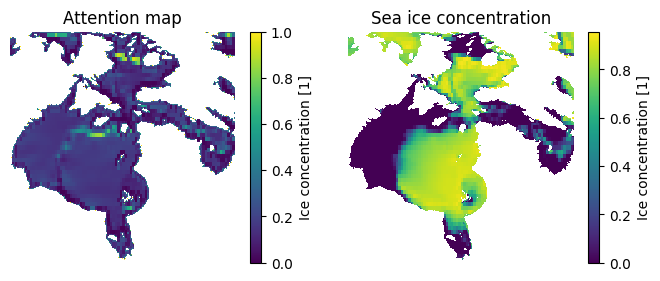

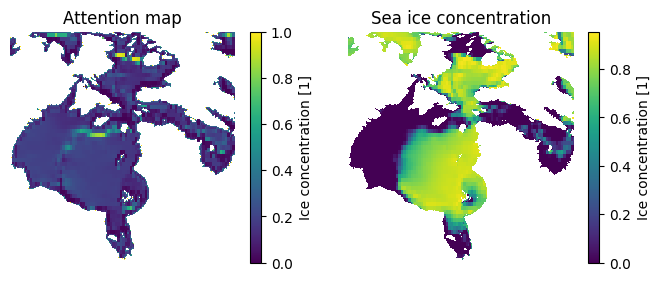

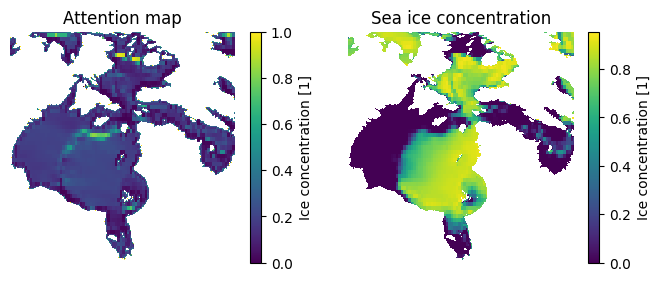

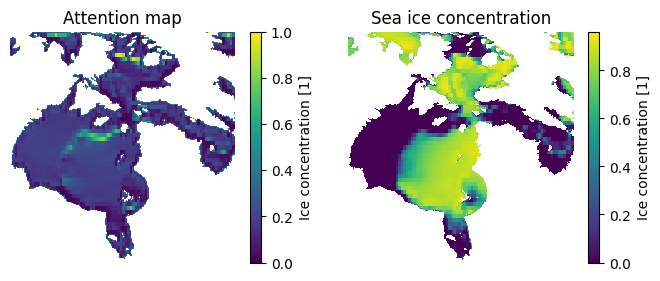

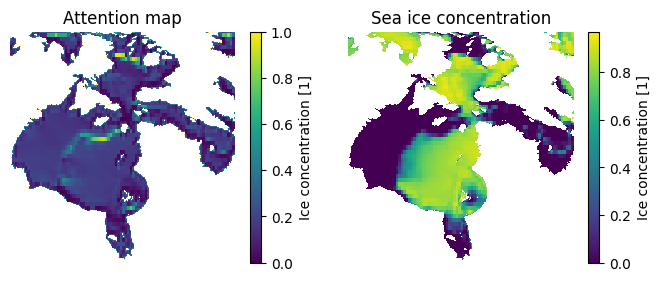

In [3]:
tmp = xr.zeros_like(ds.isel(time=0).siconc)

i = 0
fns = []
for x, att_map in zip(xs, att_maps):
    
    att_map = unflatten(torch.Tensor(att_map), graph_structure['mapping'], mask.shape)
    x = unflatten(torch.Tensor(x), graph_structure['mapping'], mask.shape)
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))

    tmp.values = att_map[..., 0]
    tmp.where(~mask).plot(ax=axs[0])

    tmp.values = x[..., 0]
    tmp.where(~mask).plot(ax=axs[1])
    
    axs[0].axis('off')
    axs[1].axis('off')
    
    axs[0].set_title('Attention map')
    axs[1].set_title('Sea ice concentration')
        
    fn = f'scratch/att_gif/{i}.png'
    plt.savefig(fn)
    fns.append(fn)
    
    plt.show()
    
    i += 1
    
    
from PIL import Image
frames = []
for fn in fns:
    new_frame = Image.open(fn)
    frames.append(new_frame)
            
frames[0].save(f'scratch/att_gif/att_map.gif',
            format='GIF',
            append_images=frames[1:],
            save_all=True,
            duration=300,
            loop=0)

for fn in fns:
    os.remove(fn)

In [19]:
x.shape

torch.Size([229, 361, 32])

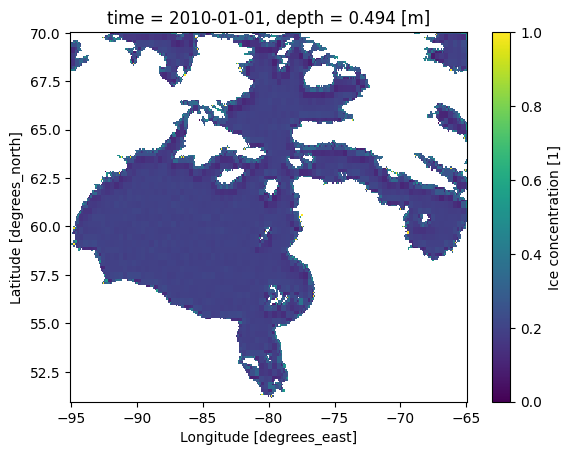

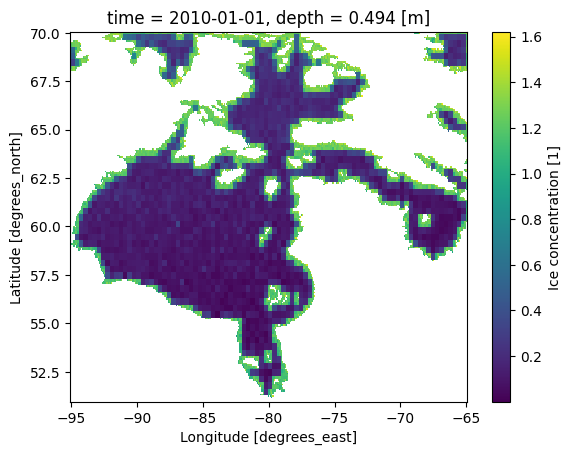

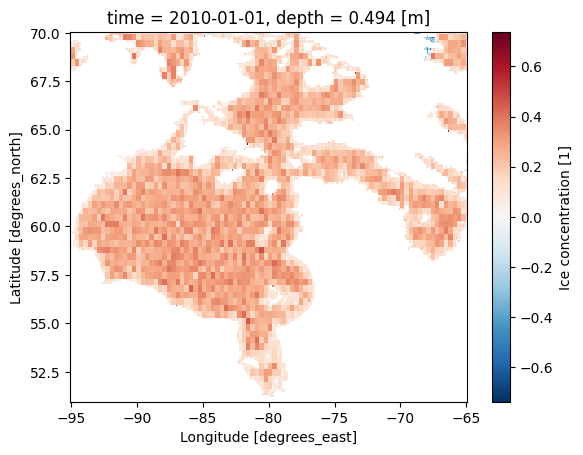

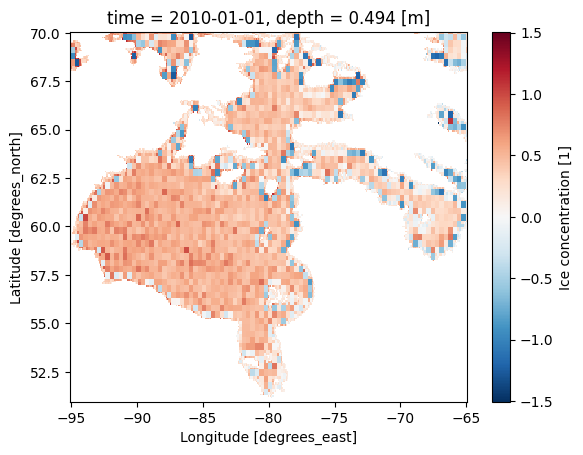

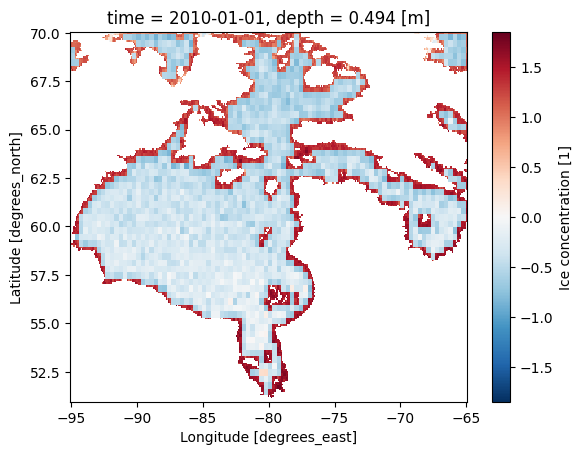

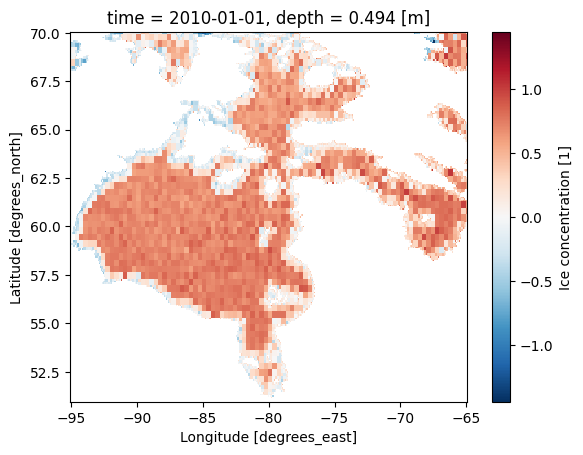

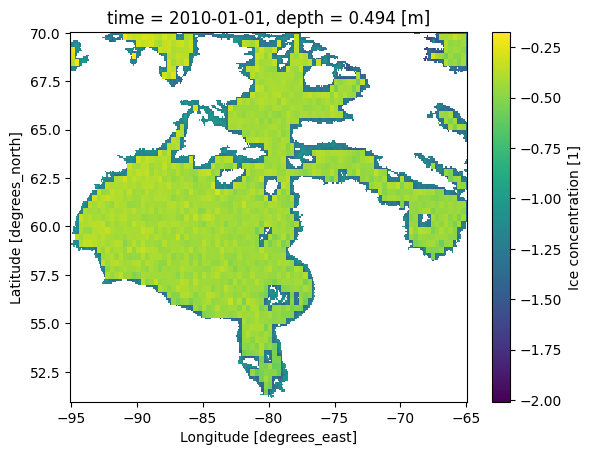

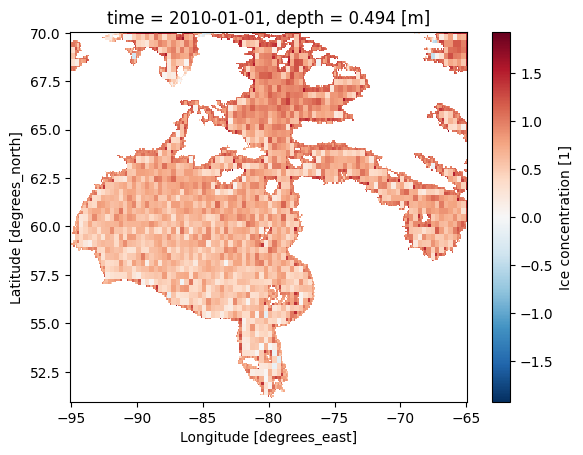

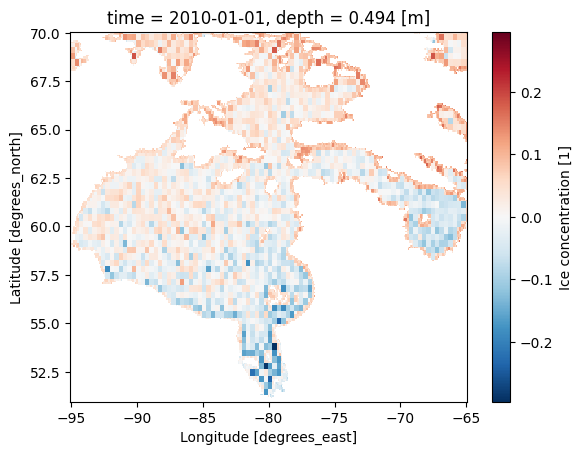

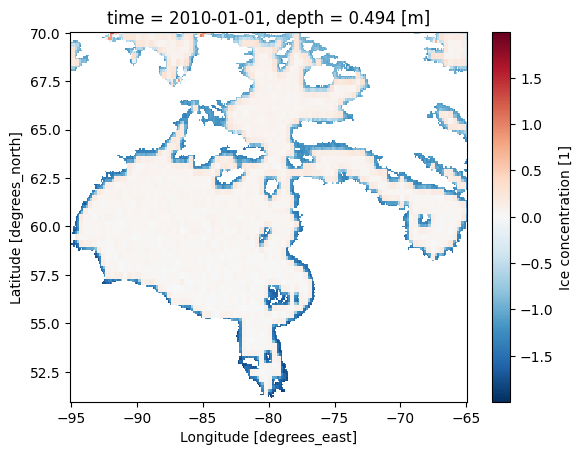

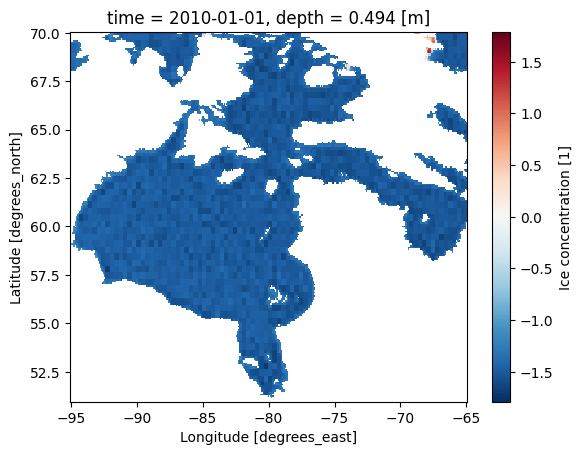

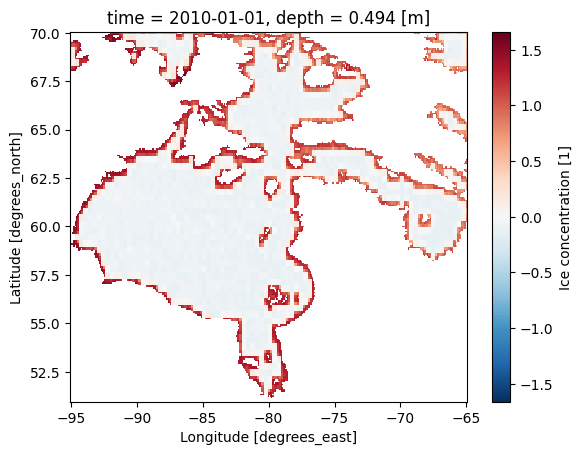

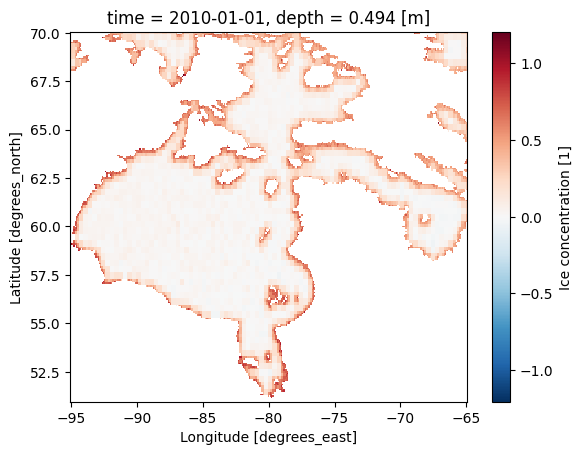

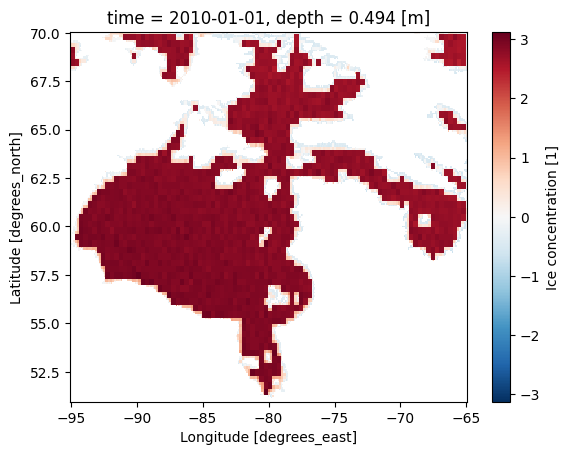

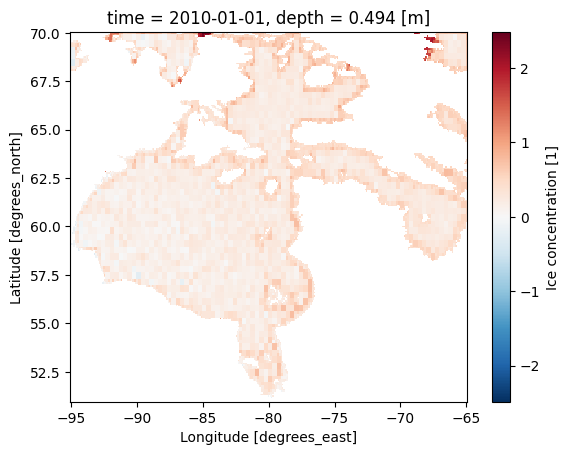

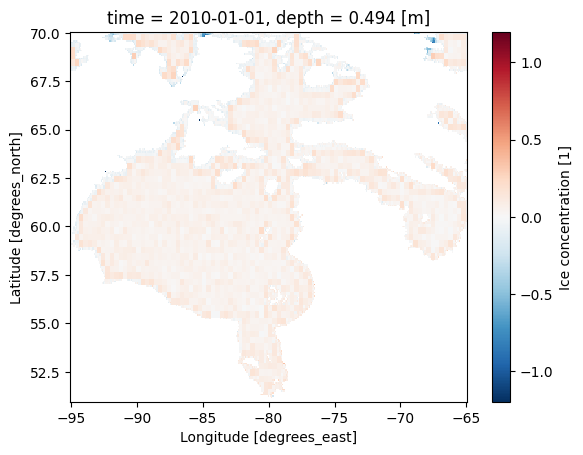

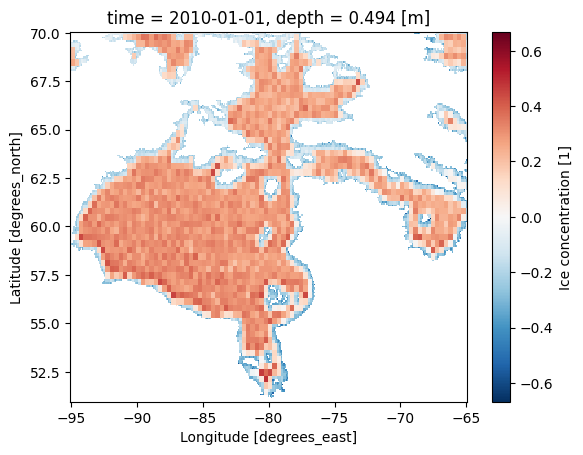

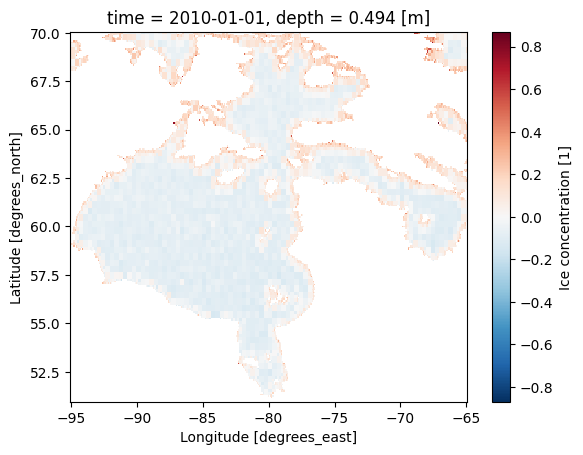

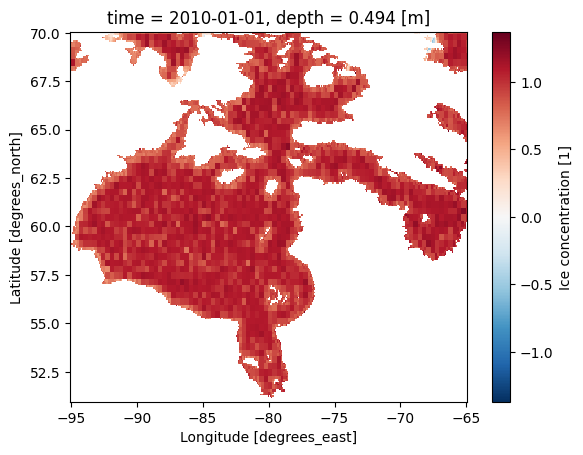

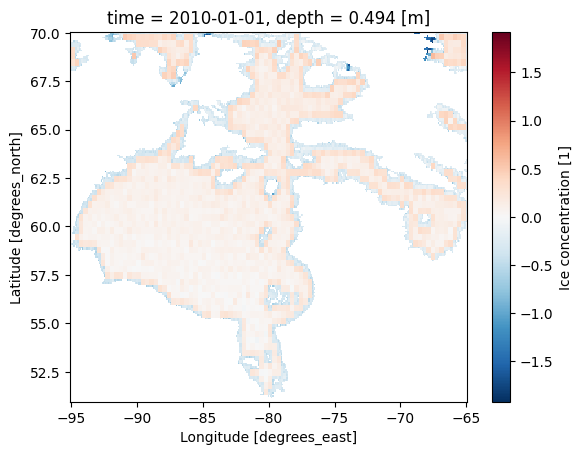

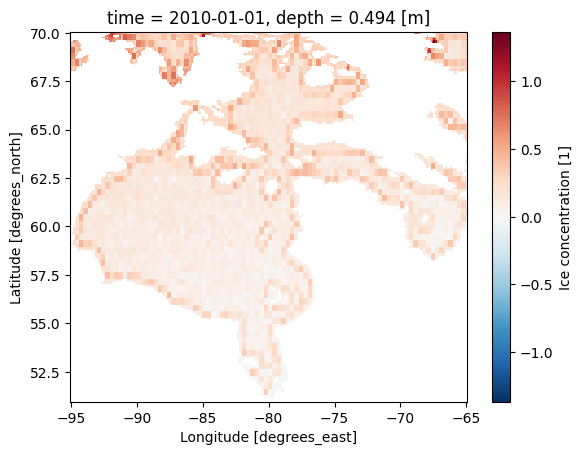

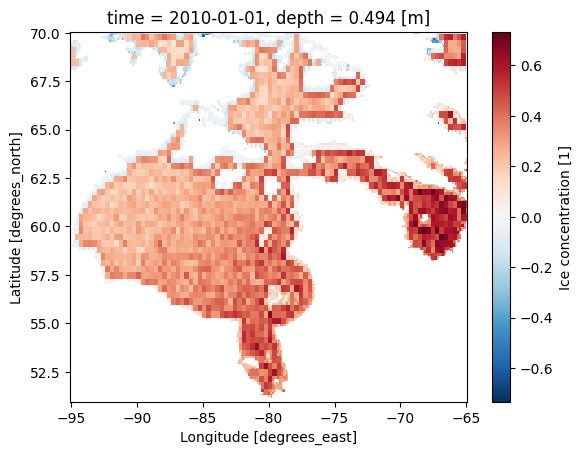

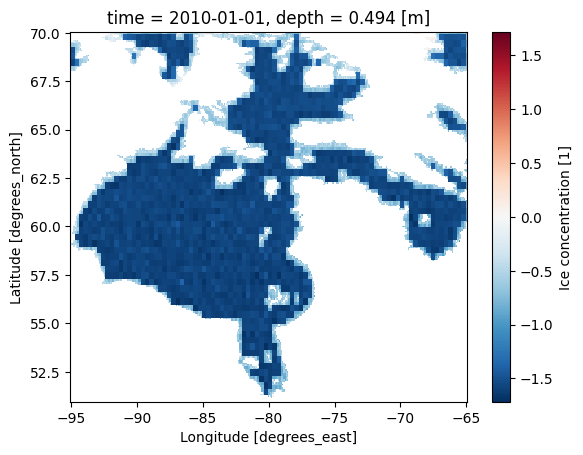

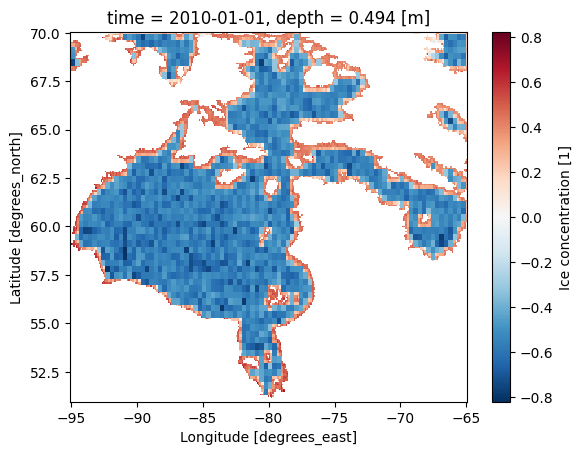

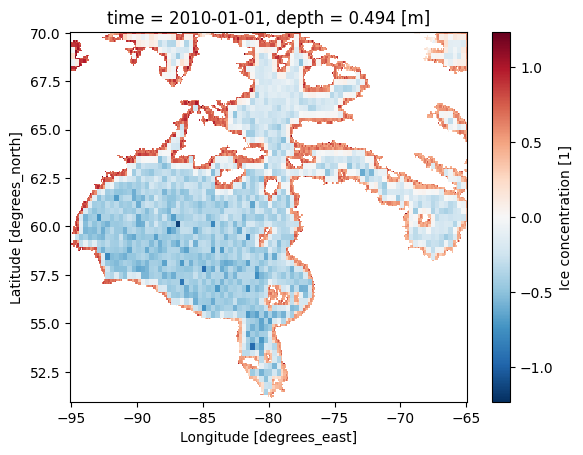

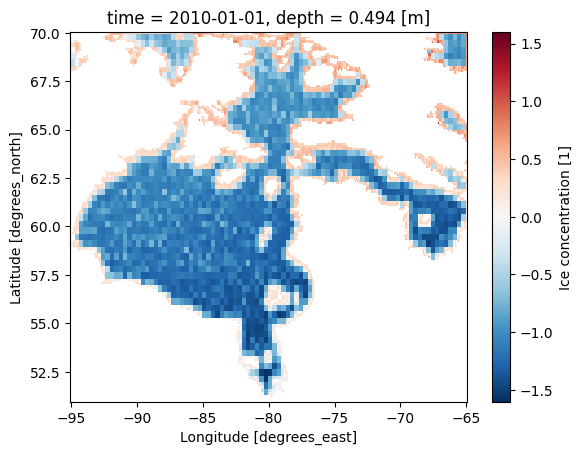

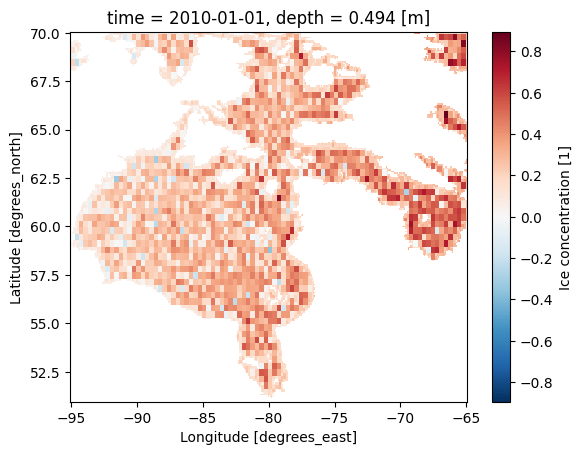

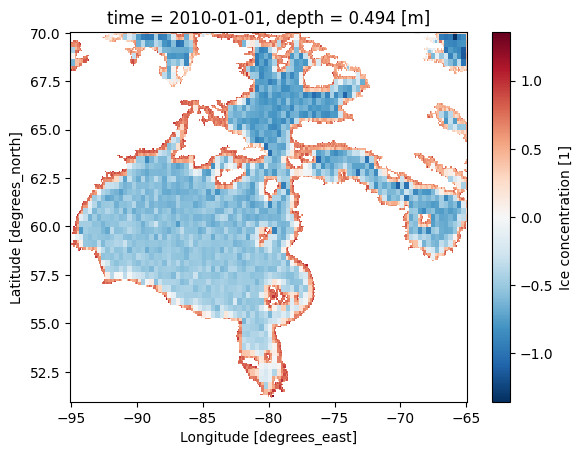

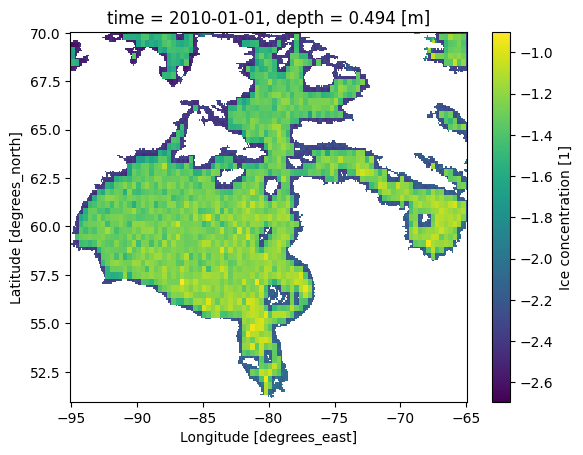

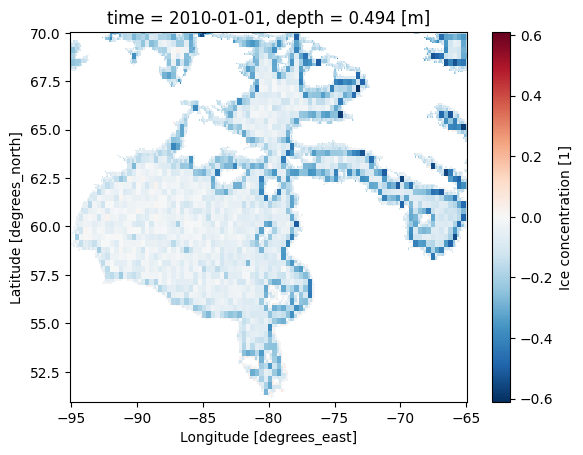

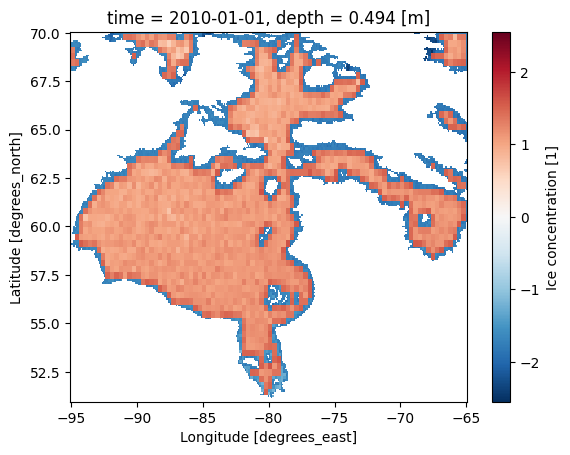

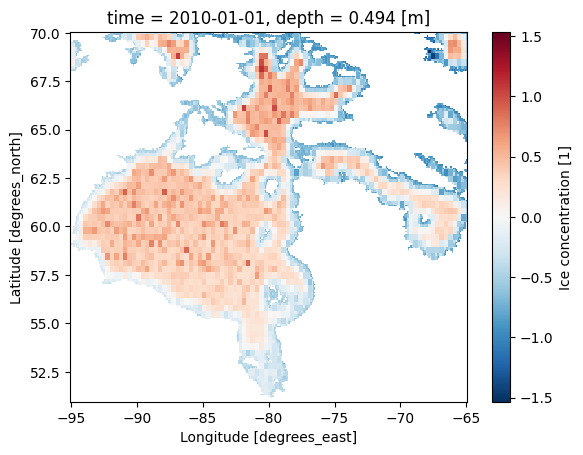

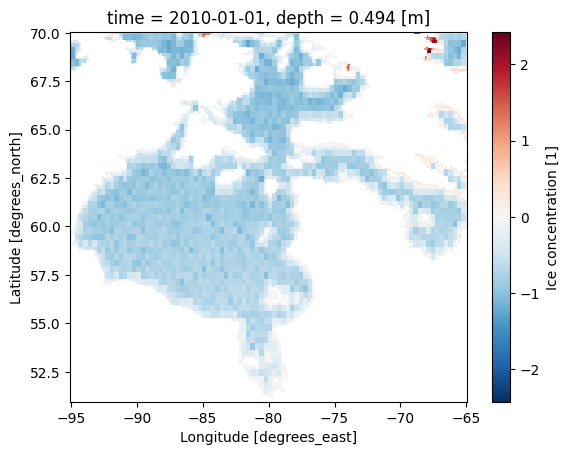

In [18]:
tmp = xr.zeros_like(ds.isel(time=0).siconc)

tmp.values = att_map[..., 0]
tmp.where(~mask).plot()
plt.show()

for i in range(x.shape[-1]):
    tmp.values = x[..., i]
    tmp.where(~mask).plot()
    plt.show()